In [1]:
from pathlib import Path
import sys

root = Path.cwd().parent
sys.path.append(str(root))

In [2]:
import wandb
import json

wandb.init()

# Opening the evolution trace artifact

trace_artifact = wandb.use_artifact("icl-research-team/ner_task/ner_evolution_trace:v4")
trace_artifact_dir = trace_artifact.download() # Downloads the artifact and returns the directory path

with open(Path(trace_artifact_dir) / "ner_evolution_trace.json") as f:
    trace_data = json.load(f)

wandb: Currently logged in as: sbfroy (icl-research-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [3]:
import pandas as pd

# Accessing the embedding dataset

embedding_artifact = wandb.use_artifact("icl-research-team/ner_task/ner_embedded_dataset:v6")
embedding_artifact_dir = embedding_artifact.download() 

embedding_df = pd.read_parquet(Path(embedding_artifact_dir) / "embedded_dataset.parquet")

wandb:   1 of 1 files downloaded.  


In [4]:
from collections import Counter

# Count how many times each example_id appears across all generations

example_usage_counts = Counter()

for generation_data in trace_data:
    examples_lists = generation_data['examples']
    for examples_list in examples_lists:
        for example_info in examples_list:
            example_id = example_info['example_id']
            example_usage_counts[example_id] += 1

# Add usage counts to the df
embedding_df['usage_count'] = embedding_df['example_id'].map(lambda x: example_usage_counts.get(x, 0))
embedding_df['is_used'] = embedding_df['usage_count'] > 0

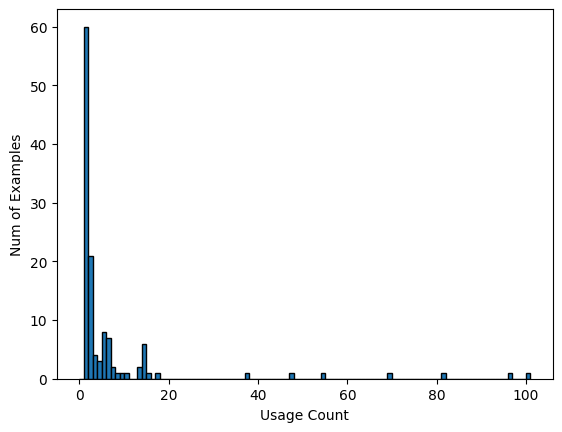

In [5]:
import numpy as np
import matplotlib.pyplot as plt

used = embedding_df.loc[embedding_df['is_used'], 'usage_count']

bins = np.arange(0, used.max() + 2, 1) 

plt.hist(used, bins=bins, edgecolor='black')                    
plt.xlabel('Usage Count')
plt.ylabel('Num of Examples')
plt.show()

In [6]:
print(f"Total examples in the dataset: {len(embedding_df)}")
print(f"Examples used during evolution: {embedding_df['is_used'].sum()} ({embedding_df['is_used'].mean()*100:.1f}%)")
print(f"Examples never used: {(~embedding_df['is_used']).sum()} ({(~embedding_df['is_used']).mean()*100:.1f}%)")

used_examples = embedding_df[embedding_df['is_used']]['usage_count']
print(f"Average usage per used example: {used_examples.mean():.1f} times")
print(f"Median usage per used example: {used_examples.median():.1f} times")

Total examples in the dataset: 1661
Examples used during evolution: 125 (7.5%)
Examples never used: 1536 (92.5%)
Average usage per used example: 7.0 times
Median usage per used example: 2.0 times


In [7]:
from sklearn.manifold import TSNE
import numpy as np

embeddings = np.vstack(embedding_df['embedding'].values)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

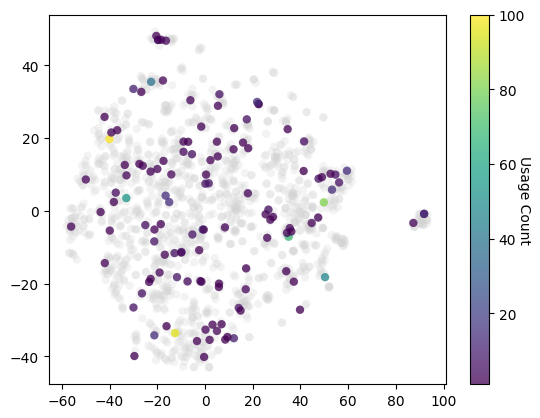

In [8]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c="lightgrey", alpha=0.25, edgecolors='none')

# Plot used examples with colors based on usage count
used_mask = embedding_df['usage_count'] > 0
used_tsne = tsne_results[used_mask]
used_counts = embedding_df[used_mask]['usage_count'].values

min_usage = used_counts.min()
max_usage = used_counts.max()

scatter = plt.scatter(used_tsne[:, 0], used_tsne[:, 1], 
                     c=used_counts,
                     alpha=0.75,   
                     edgecolors='none',
                     vmin=min_usage,
                     vmax=max_usage)

cbar = plt.colorbar(scatter) # Add colorbar
cbar.set_label('Usage Count', rotation=270)

plt.show()

In [9]:
embedding_df['tsne_x'] = tsne_results[:, 0]
embedding_df['tsne_y'] = tsne_results[:, 1]

# Process trace_data to create proper generation_data structure
generation_data = []

for gen_data in trace_data:
    if isinstance(gen_data, dict):
        # Extract example_ids from the examples structure
        example_ids = []
        if 'examples' in gen_data:
            for examples_list in gen_data['examples']:
                for example_info in examples_list:
                    if isinstance(example_info, dict) and 'example_id' in example_info:
                        example_ids.append(example_info['example_id'])
        
        # Get coordinates for selected examples
        selected_mask = embedding_df['example_id'].isin(example_ids)
        coords = tsne_results[selected_mask].tolist()
        
        generation_data.append({
            'generation': gen_data.get('generation', len(generation_data)),
            'example_ids': example_ids,
            'coords': coords
        })

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

frames = []
all_examples_df = embedding_df.copy()

for gen_idx, gen_data in enumerate(generation_data):
    # Create a temporary dataframe for this generation
    gen_df = all_examples_df.copy()
    gen_df['selected_in_gen'] = gen_df['example_id'].isin(gen_data['example_ids'])
    gen_df['marker_size'] = gen_df['selected_in_gen'].apply(lambda x: 8 if x else 4)
    gen_df['marker_color'] = gen_df['selected_in_gen'].apply(lambda x: 'red' if x else 'lightgray')
    gen_df['marker_opacity'] = gen_df['selected_in_gen'].apply(lambda x: 0.9 if x else 0.3)
    
    # Create frame
    frame = go.Frame(
        data=[
            go.Scatter(
                x=gen_df['tsne_x'],
                y=gen_df['tsne_y'],
                mode='markers',
                marker=dict(
                    size=gen_df['marker_size'],
                    color=gen_df['marker_color'],
                    opacity=gen_df['marker_opacity'],
                    line=dict(width=0.5, color='white')
                ),
                text=gen_df['example_id'],
                hovertemplate='<b>Example ID:</b> %{text}<br>' +
                             '<b>Selected:</b> %{customdata}<br>' +
                             '<extra></extra>',
                customdata=gen_df['selected_in_gen'].apply(lambda x: 'Yes' if x else 'No')
            )
        ],
        name=f'Generation {gen_data["generation"]}',
        layout=go.Layout(
            title=f'Generation {gen_data["generation"]} - Selected Examples: {len(gen_data["example_ids"])}'
        )
    )
    frames.append(frame)

# Create initial plot (Generation 0)
initial_gen = generation_data[0]
initial_df = all_examples_df.copy()
initial_df['selected_in_gen'] = initial_df['example_id'].isin(initial_gen['example_ids'])
initial_df['marker_size'] = initial_df['selected_in_gen'].apply(lambda x: 8 if x else 4)
initial_df['marker_color'] = initial_df['selected_in_gen'].apply(lambda x: 'red' if x else 'lightgray')
initial_df['marker_opacity'] = initial_df['selected_in_gen'].apply(lambda x: 0.9 if x else 0.3)

fig_anim = go.Figure(
    data=[
        go.Scatter(
            x=initial_df['tsne_x'],
            y=initial_df['tsne_y'],
            mode='markers',
            marker=dict(
                size=initial_df['marker_size'],
                color=initial_df['marker_color'],
                opacity=initial_df['marker_opacity'],
                line=dict(width=0.5, color='white')
            ),
            text=initial_df['example_id'],
            hovertemplate='<b>Example ID:</b> %{text}<br>' +
                         '<b>Selected:</b> %{customdata}<br>' +
                         '<extra></extra>',
            customdata=initial_df['selected_in_gen'].apply(lambda x: 'Yes' if x else 'No'),
            name='Examples'
        )
    ],
    frames=frames
)

# Update layout with animation controls
fig_anim.update_layout(
    title='Evolution Timelapse: Example Selection Across Generations<br><sub>Click play to see evolution progression</sub>',
    xaxis_title='t-SNE Dimension 1',
    yaxis_title='t-SNE Dimension 2',
    width=900,
    height=700,
    showlegend=False,
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'buttons': [
            {
                'label': '▶ Play',
                'method': 'animate',
                'args': [None, {
                    'frame': {'duration': 1000, 'redraw': True},
                    'fromcurrent': True,
                    'transition': {'duration': 300}
                }]
            },
            {
                'label': '⏸ Pause',
                'method': 'animate',
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': False},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Generation: ',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [
            {
                'args': [[f'Generation {gen_data["generation"]}'], {
                    'frame': {'duration': 300, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 300}
                }],
                'label': f'Gen {gen_data["generation"]}',
                'method': 'animate'
            }
            for gen_data in generation_data
        ]
    }]
)

fig_anim.show()

In [11]:
# Create a static subplot showing all generations side-by-side
from math import ceil

# Calculate subplot layout (try to make it roughly square)
n_gens = len(generation_data)
n_cols = min(4, n_gens)  # Max 4 columns
n_rows = ceil(n_gens / n_cols)

fig_grid = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=[f'Generation {gen_data["generation"]} ({len(gen_data["example_ids"])} examples)' 
                   for gen_data in generation_data],
    horizontal_spacing=0.05,
    vertical_spacing=0.1
)

# Add traces for each generation
for i, gen_data in enumerate(generation_data):
    row = i // n_cols + 1
    col = i % n_cols + 1
    
    # Background points (all examples)
    fig_grid.add_trace(
        go.Scatter(
            x=tsne_results[:, 0],
            y=tsne_results[:, 1],
            mode='markers',
            marker=dict(
                size=3,
                color='lightgray',
                opacity=0.3
            ),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=row, col=col
    )
    
    # Selected examples for this generation
    if gen_data['coords']:
        coords_array = np.array(gen_data['coords'])
        fig_grid.add_trace(
            go.Scatter(
                x=coords_array[:, 0],
                y=coords_array[:, 1],
                mode='markers',
                marker=dict(
                    size=6,
                    color='red',
                    opacity=0.8,
                    line=dict(width=1, color='white')
                ),
                showlegend=False,
                text=gen_data['example_ids'],
                hovertemplate='<b>Example ID:</b> %{text}<extra></extra>'
            ),
            row=row, col=col
        )

fig_grid.update_layout(
    title='Evolution Across All Generations - Side by Side Comparison<br><sub>Red dots show selected examples for each generation</sub>',
    height=300 * n_rows,
    width=1200,
    showlegend=False
)

# Remove axis labels for cleaner look
fig_grid.update_xaxes(showticklabels=False)
fig_grid.update_yaxes(showticklabels=False)

fig_grid.show()

print(f"Static comparison created showing all {n_gens} generations!")
print("\nEvolution summary:")
print("The algorithm shows convergence behavior:")
print(f"• Started with {generation_data[0]['example_ids'].__len__()} examples in Generation 0")
print(f"• Converged to {generation_data[-1]['example_ids'].__len__()} examples in Generation {generation_data[-1]['generation']}")
print(f"• Reduction ratio: {generation_data[-1]['example_ids'].__len__() / generation_data[0]['example_ids'].__len__():.1%}")
print("• This shows the evolution process is successfully narrowing down to the most relevant examples")

Static comparison created showing all 7 generations!

Evolution summary:
The algorithm shows convergence behavior:
• Started with 125 examples in Generation 0
• Converged to 125 examples in Generation 6
• Reduction ratio: 100.0%
• This shows the evolution process is successfully narrowing down to the most relevant examples
